In [1]:
#RFM Features: Recency, frequency and monetary #Customer Lifetime Value

In [5]:
pip install plydata

In [80]:
# Installing dependencies
import numpy as np
import pandas as pd
import joblib
import plydata.cat_tools as cat
import plotnine as pn
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import GridSearchCV

In [7]:
file='/content/CDNOW_master.txt'
df=pd.read_table(file, sep='\s+',names=['customer_id','date','quantity','price'])

In [8]:
df.sample(5)

,customer_id,date,quantity,price
21884,7036,19970127,1,5.99
23695,7592,19971110,7,153.43
46177,15171,19970314,2,32.92
63583,21448,19970317,1,18.76
16675,5270,19970121,4,46.47


In [9]:
#this makes the graph's look more crisp
pn.options.dpi=300

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [11]:
print(df.shape)

(69659, 4)


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
customer_id,69659.0,1.147085e+04,6819.904848,1.0,5506.00,11410.00,17273.0,23570.00
date,69659.0,1.997228e+07,3837.734614,19970101.0,19970222.00,19970424.00,19971107.0,19980630.00
quantity,69659.0,2.410040e+00,2.333924,1.0,1.00,2.00,3.0,99.00
price,69659.0,3.589365e+01,36.281942,0.0,14.49,25.98,43.7,1286.01


In [13]:
df_new=df.assign(date=lambda x:x['date'].astype(str))
df_new=df_new.assign(date=lambda x:pd.to_datetime(x['date']))

In [14]:
df_new.head()

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [15]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


In [16]:
#COHORT analysis: customer's who have joined in a specific time window

In [17]:
tbl_first_purchase=df_new.sort_values(['customer_id','date']).groupby(['customer_id']).first()

In [18]:
print(tbl_first_purchase.shape)

(23570, 3)


In [19]:
#date window 
tbl_first_purchase['date'].min()

Timestamp('1997-01-01 00:00:00')

In [20]:
tbl_first_purchase['date'].max()

Timestamp('1997-03-25 00:00:00')

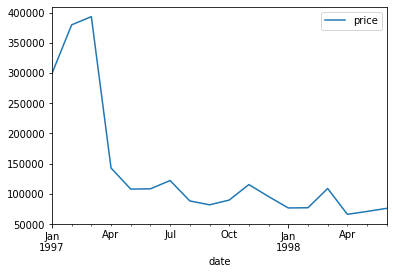

In [21]:
#Visualize all purchases within cohort
df_new.reset_index().set_index('date')[['price']].resample(rule='MS').sum().plot()

In [22]:
# visualising individual customer purchase
ids=df_new['customer_id'].unique()
ids_selected=ids[0:10]

In [23]:
ids_selected

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [24]:
cust_id_subset=df_new[df_new['customer_id'].isin(ids_selected)].groupby(['customer_id','date']).sum().reset_index()

/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  "group aesthetic?", PlotnineWarning)


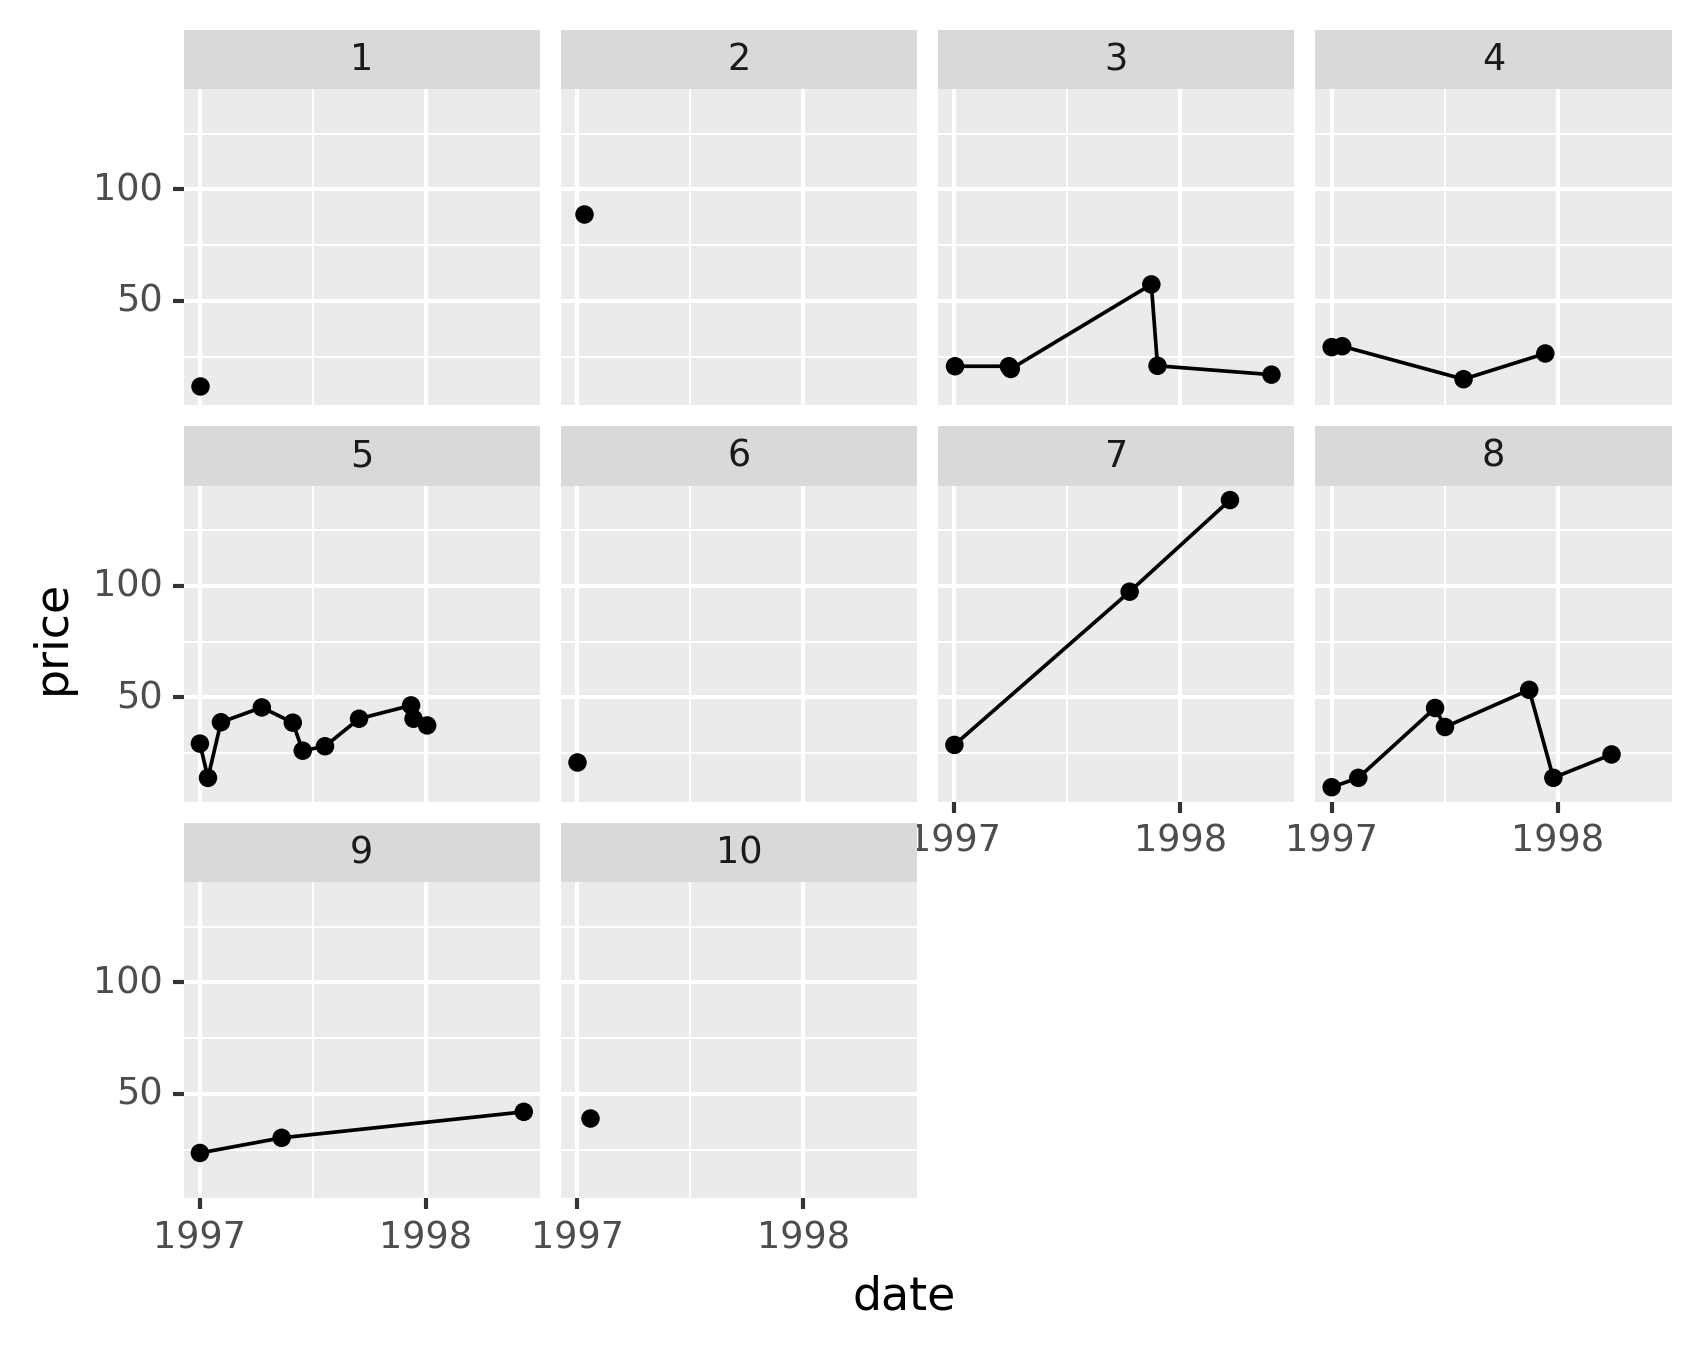

<ggplot: (8760291796801)>

In [25]:
#customer buying pattern 
pn.ggplot(
    pn.aes('date','price',group='customer_id'),
    data=cust_id_subset)\
    +pn.geom_line()\
    +pn.geom_point()\
    +pn.facet_wrap('customer_id')\
    +pn.scale_x_date(
        date_breaks='1 year',date_labels='%Y'
        )

In [26]:
# ML 
# Prob 1: What will customer's spend in next 90 days? (Regression)
# Prob 2: What is the prob. of a customer to make a purchase in next 90 days? (Classification)

In [27]:
#Time split Stage 1
# Prediction for 90 days
n_days=90
max_date=df_new['date'].max()
cutoff=max_date-pd.to_timedelta(n_days,unit='d')

In [28]:
#dates within ninty days
temporal_in_df=df_new[df_new['date']<=cutoff]

In [29]:
#dates outside ninty days
temporal_out_df=df_new[df_new['date']>cutoff]

In [34]:
#feature engineering (rfm) --
#creating target's out of data
targets_df=temporal_out_df.drop('quantity',axis=1).groupby('customer_id').sum().rename({'price':'spend_90s_total'},axis=1).assign(spend_90s_flag=1)

In [35]:
targets_df

,spend_90s_total,spend_90s_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1
...,...,...
23529,40.56,1
23534,10.48,1
23555,77.44,1


In [36]:
#make recency features from in data
max_date=temporal_in_df['date'].max()

In [37]:
recency_features_df=temporal_in_df[['customer_id','date']].groupby('customer_id').apply(lambda x: (x['date'].max()-max_date)/pd.to_timedelta(1,"day")).to_frame().set_axis(["recency"],axis=1)

In [38]:
recency_features_df

,recency
customer_id,
1,-455.0
2,-444.0
3,-127.0
4,-110.0
5,-88.0
...,...
23566,-372.0
23567,-372.0
23568,-344.0


In [39]:
#frequency count
frequency_features_df=temporal_in_df[['customer_id','date']].groupby('customer_id').count().set_axis(['frequency'],axis=1)

In [40]:
frequency_features_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


In [42]:
price_features_df=temporal_in_df.groupby('customer_id').aggregate({'price':['sum','mean']}).set_axis(['price_sum','price_mean'],axis=1)
price_features_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


In [43]:
#combining the features
features_df=pd.concat([recency_features_df,frequency_features_df,price_features_df],axis=1).merge(targets_df,left_index=True,right_index=True,how='left').fillna(0)
features_df

,recency,frequency,price_sum,price_mean,spend_90s_total,spend_90s_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,89.00,44.500000,0.00,0.0
3,-127.0,5,139.47,27.894000,16.99,1.0
4,-110.0,4,100.50,25.125000,0.00,0.0
5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,-372.0,1,36.00,36.000000,0.00,0.0
23567,-372.0,1,20.97,20.970000,0.00,0.0
23568,-344.0,3,121.70,40.566667,0.00,0.0


In [44]:
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import GridSearchCV

In [45]:
#Regressor's
x=features_df[['recency','frequency','price_sum','price_mean']]
#target
y_spend=features_df['spend_90s_total']

In [46]:
xgb_reg_spec=XGBRegressor(objective='reg:squarederror',random_state=43)
xgb_reg_model=GridSearchCV(estimator=xgb_reg_spec,param_grid=dict(learning_rate=[0.01,0.1,0.3,0.5]),scoring='neg_mean_absolute_error',refit=True,cv=5)
#cv is cross validation: 80-20 split and do it 5 times and create 5 models
#refit = creates 6th model

In [47]:
xgb_reg_model.fit(x,y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(objective='reg:squarederror',
                                    random_state=43),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [50]:
print('The price prediction is offset by {} amount'.format(xgb_reg_model.best_score_)) 

The price prediction is offset by -10.135846807861208 amount


In [51]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [53]:
xgb_reg_model.best_estimator_

XGBRegressor(learning_rate=0.01, objective='reg:squarederror', random_state=43)

In [54]:
predictions_reg=xgb_reg_model.predict(x)
predictions_reg

array([1.7315966, 1.7897931, 6.5675673, ..., 2.1968884, 1.7315966,
       1.7897931], dtype=float32)

In [56]:
#NEXT 90 day spend probability
y_prob=features_df['spend_90s_flag']
xgb_clf_spec=XGBClassifier(objective="binary:logistic",random_state=43)
xgb_clf_model=GridSearchCV(estimator=xgb_clf_spec,param_grid=dict(learning_rate=[0.01,0.3,0.5]),scoring='roc_auc',refit=True,cv=5)
#AUC=area under curve

In [57]:
xgb_clf_model.fit(x,y_prob)

GridSearchCV(cv=5, estimator=XGBClassifier(random_state=43),
             param_grid={'learning_rate': [0.01, 0.3, 0.5]}, scoring='roc_auc')

In [58]:
xgb_clf_model.best_score_

0.837149769386276

In [59]:
xgb_clf_model.best_params_

{'learning_rate': 0.01}

In [61]:
xgb_clf_model.best_estimator_

XGBClassifier(learning_rate=0.01, random_state=43)

In [63]:
predictions_clf=xgb_clf_model.predict_proba(x)

In [64]:
predictions_clf

array([[0.79787743, 0.2021226 ],
       [0.7850191 , 0.2149809 ],
       [0.6432823 , 0.35671768],
       ...,
       [0.75820845, 0.24179153],
       [0.7966206 , 0.20337942],
       [0.783704  , 0.216296  ]], dtype=float32)

In [67]:
#FEATURE IMPORTANCE
#Importance | spend amount model
imp_spend_amount_dict=xgb_reg_model.best_estimator_.get_booster().get_score(importance_type='gain')

In [68]:
imp_spend_amount_df=pd.DataFrame(data={'feature':list(imp_spend_amount_dict.keys()),
                                       'value':list(imp_spend_amount_dict.values())}).assign(feature=lambda x:cat.cat_reorder(x['feature'],x['value']))

In [69]:
imp_spend_amount_df

,feature,value
0,price_sum,2.730946e+06
1,recency,6.693140e+05
2,frequency,6.000831e+05
3,price_mean,2.764157e+05


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


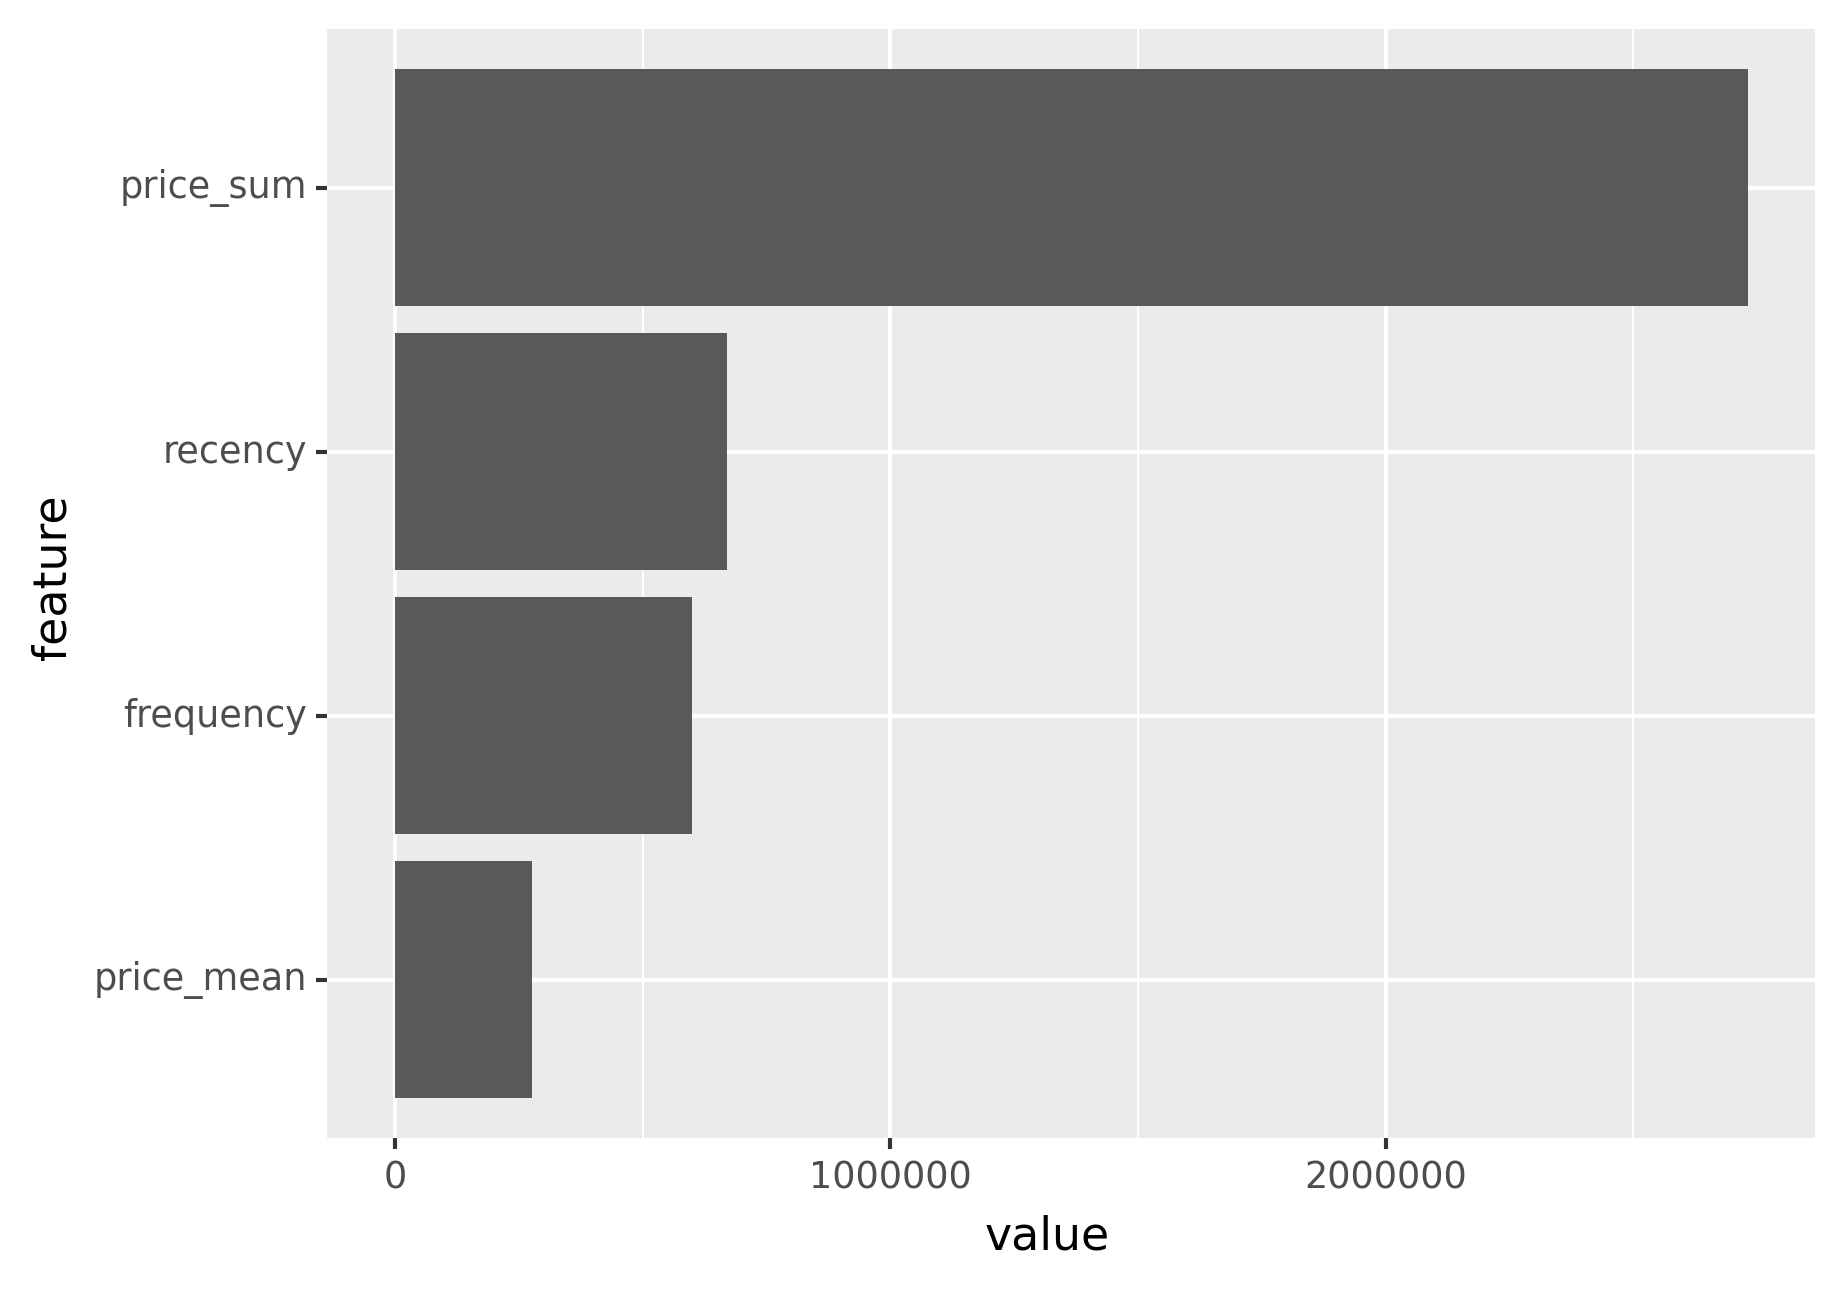

<ggplot: (8760286825385)>

In [83]:
pn.ggplot(pn.aes('feature','value'),data=imp_spend_amount_df)\
+pn.geom_col()\
+pn.coord_flip()

In [84]:
#Importance| spend probability model
imp_spend_prob_dict=xgb_clf_model.best_estimator_.get_booster().get_score(importance_type='gain')

In [85]:
imp_spend_prob_df=pd.DataFrame(data={'feature':list(imp_spend_prob_dict.keys()),
                                       'value':list(imp_spend_prob_dict.values())}).assign(feature=lambda x:cat.cat_reorder(x['feature'],x['value']))

In [86]:
imp_spend_prob_df

,feature,value
0,recency,305.519922
1,frequency,128.098293
2,price_sum,5.638036
3,price_mean,7.642273


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


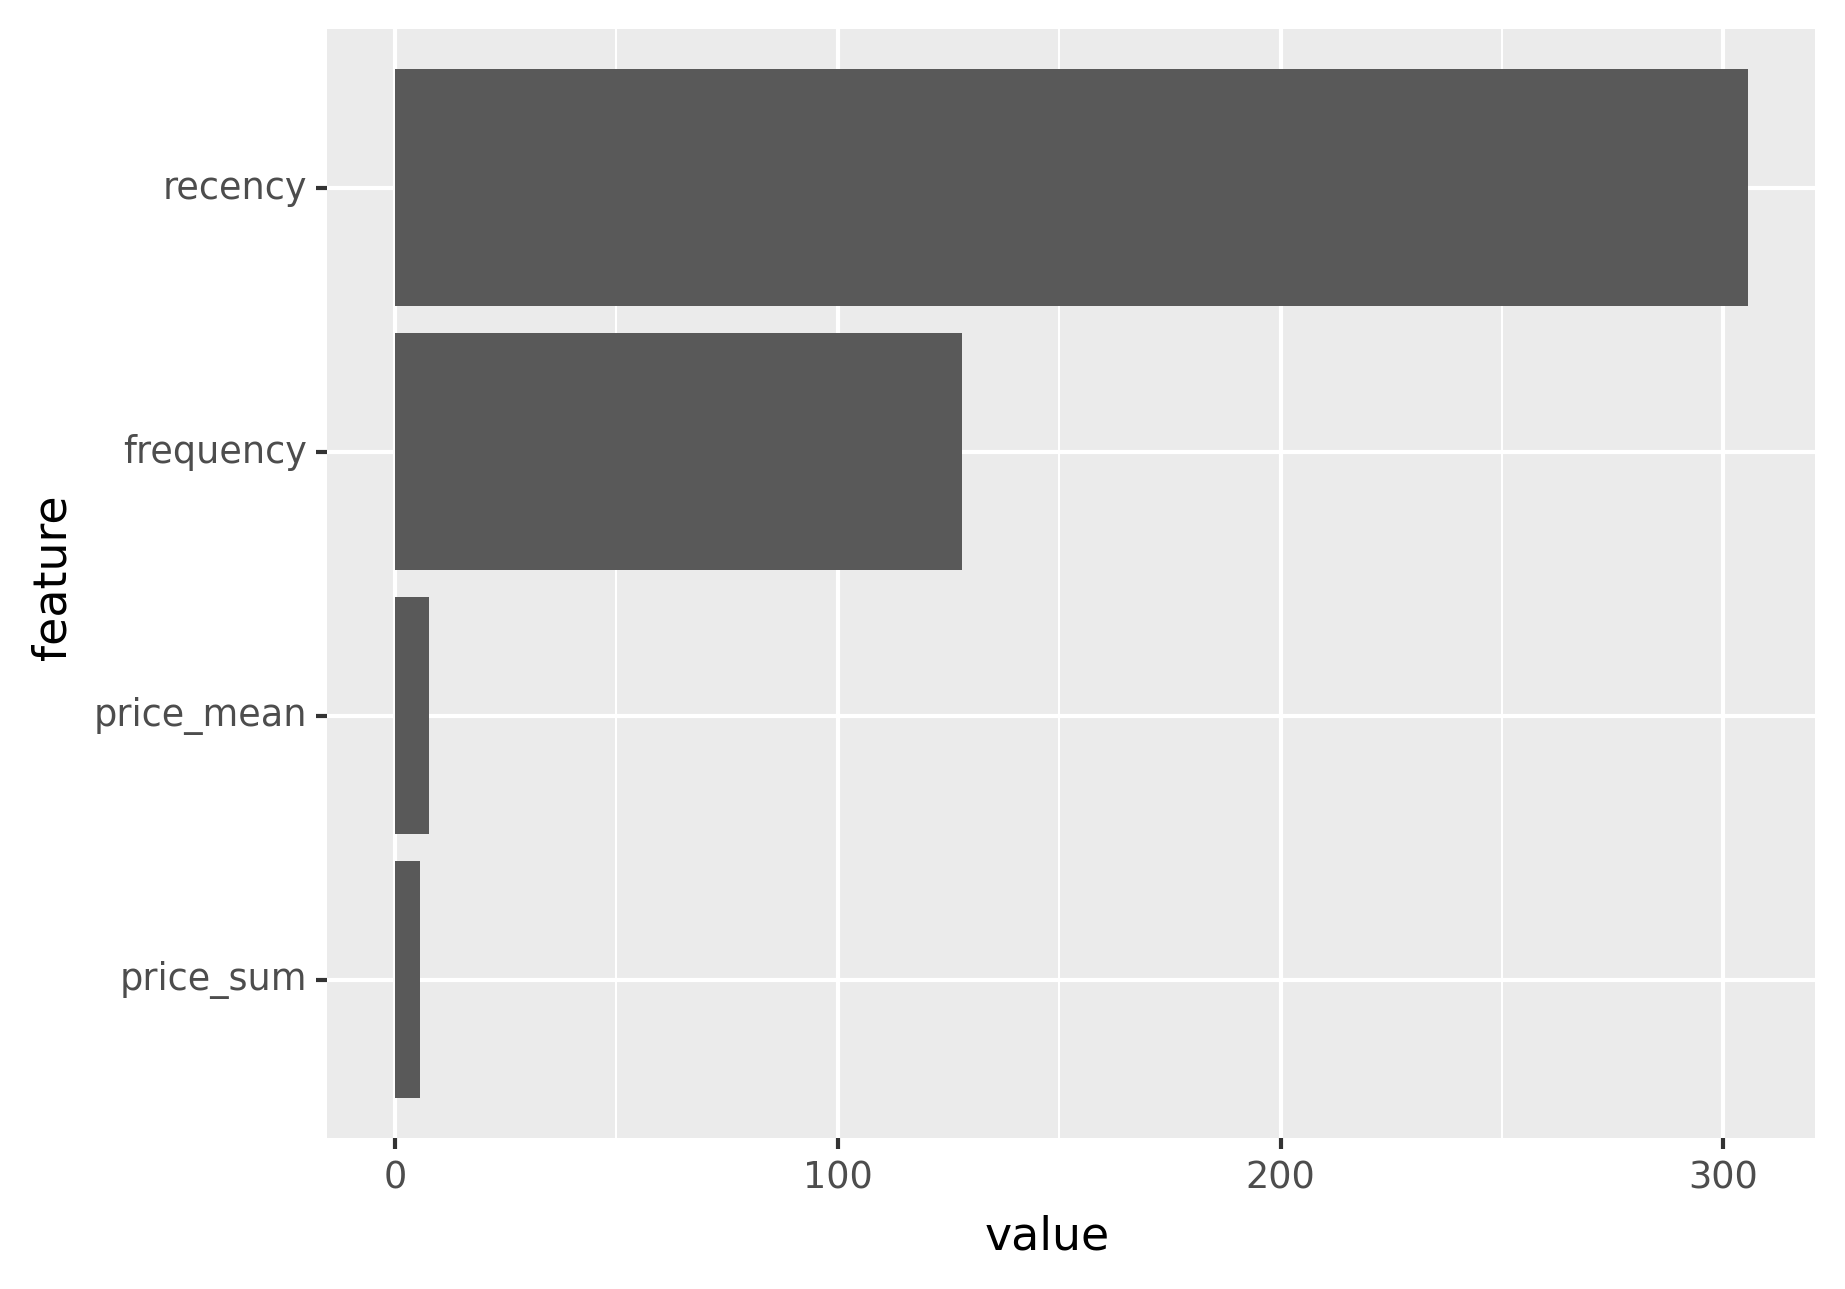

<ggplot: (8760286859373)>

In [87]:
pn.ggplot(pn.aes('feature','value'),data=imp_spend_prob_df)\
+pn.geom_col()\
+pn.coord_flip()

In [90]:
predictions_df=pd.concat(
   [ pd.DataFrame(predictions_reg).set_axis(['pred_spend'],axis=1),
    pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'],axis=1),
    features_df.reset_index()
   ],
axis=1
)

In [92]:
predictions_df

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90s_total,spend_90s_flag
0,1.731597,0.202123,1,-455.0,1,11.77,11.770000,0.00,0.0
1,1.789793,0.214981,2,-444.0,2,89.00,44.500000,0.00,0.0
2,6.567567,0.356718,3,-127.0,5,139.47,27.894000,16.99,1.0
3,5.892581,0.357396,4,-110.0,4,100.50,25.125000,0.00,0.0
4,21.155424,0.579524,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,1.731597,0.203379,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,1.731597,0.203379,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,2.196888,0.241792,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,1.731597,0.203379,23569,-372.0,1,25.74,25.740000,0.00,0.0


Customer's which have highest spend probability in the next 90 day. -- Team can target similar products which they have already purchased

In [93]:
predictions_df.sort_values('pred_prob',ascending=False)

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90s_total,spend_90s_flag
11692,26.645624,0.640399,11693,-22.0,12,422.60,35.216667,27.58,1.0
22793,60.851189,0.640399,22794,-12.0,16,684.76,42.797500,102.43,1.0
16370,14.535760,0.640399,16371,-11.0,10,214.85,21.485000,10.49,1.0
22623,55.323090,0.640399,22624,-3.0,13,529.15,40.703846,0.00,0.0
709,153.482727,0.640399,710,-2.0,51,2216.45,43.459804,285.85,1.0
...,...,...,...,...,...,...,...,...,...
8601,1.731597,0.202123,8602,-424.0,1,20.99,20.990000,0.00,0.0
8603,1.731597,0.202123,8604,-424.0,1,19.75,19.750000,0.00,0.0
8610,1.731597,0.202123,8611,-423.0,1,56.69,56.690000,0.00,0.0
8611,1.731597,0.202123,8612,-423.0,1,13.97,13.970000,0.00,0.0


Customer's which have recently purchased but runlikely to buy


In [100]:
predictions_df[predictions_df['recency']> -90][predictions_df['pred_prob']<0.20].sort_values('pred_prob',ascending=False)
predictions_df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90s_total,spend_90s_flag
0,1.731597,0.202123,1,-455.0,1,11.77,11.770000,0.00,0.0
1,1.789793,0.214981,2,-444.0,2,89.00,44.500000,0.00,0.0
2,6.567567,0.356718,3,-127.0,5,139.47,27.894000,16.99,1.0
3,5.892581,0.357396,4,-110.0,4,100.50,25.125000,0.00,0.0
4,21.155424,0.579524,5,-88.0,11,385.61,35.055455,0.00,0.0


In [97]:
#Missed opportunities
predictions_df[predictions_df['spend_90s_total']==0.0].sort_values('pred_spend',ascending=False)

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90s_total,spend_90s_flag
21684,153.482727,0.640399,21685,-14.0,25,2031.06,81.242400,0.0,0.0
17522,132.530075,0.640399,17523,-5.0,17,2280.08,134.122353,0.0,0.0
20943,94.241707,0.640399,20944,-18.0,15,1554.08,103.605333,0.0,0.0
1160,94.241707,0.640399,1161,-10.0,11,1244.34,113.121818,0.0,0.0
1589,94.241707,0.640399,1590,-19.0,11,1327.23,120.657273,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5727,1.731597,0.202123,5728,-433.0,1,40.46,40.460000,0.0,0.0
5726,1.731597,0.246441,5727,-346.0,2,39.67,19.835000,0.0,0.0
13595,1.731597,0.203379,13596,-407.0,1,12.77,12.770000,0.0,0.0
0,1.731597,0.202123,1,-455.0,1,11.77,11.770000,0.0,0.0


In [ ]:
#Next steps: automl, hyper parameter tuning, when will customer's purchase [forecasting], web apps/api's/productions 